In [262]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

def vortex_dynamics(t, state, kappa):
    '''
    Computes the time derivative of the state for a system of N point vortices.
    Args:
        t: Time (required by the solver, but not used in the autonomous system).
        state: A 1D array of shape 2N containing the vortex positions
                in the format [x1, y1, x2, y2, ...].
        kappa: A 1D array of shape N containing the strength of each vortex.
    Returns:
        A 1D array of shape 2N containing the vortex velocities [vx1, vy1, vx2, vy2, ...].
    '''
    N = len(kappa)
    positions = state.reshape((N, 2))

    # Calculate pairwise differences and squared distances vectorised
    diffs = positions[:, np.newaxis, :] - positions[np.newaxis, :, :]
    r_sq = np.sum(diffs**2, axis=2)
    np.fill_diagonal(r_sq, np.inf) # Avoid division by zero for self-interaction

    # Separate x and y components of the differences
    dx = diffs[:, :, 0]
    dy = diffs[:, :, 1]

    # Calculate velocities by summing contributions from all other vortices
    vx = - (1 / (2 * np.pi)) * np.sum(kappa * dy / r_sq, axis=1)
    vy =   (1 / (2 * np.pi)) * np.sum(kappa * dx / r_sq, axis=1)

    return np.vstack((vx, vy)).T.flatten()

def setup_and_run_simulation(initial_pos, kappa, t_span, t_eval_points=500, rtol = 1e-6):
    '''
    Sets up and runs the ODE integration for a given vortex system.
    '''
    # Flatten initial positions for the solver
    y0 = initial_pos.flatten()
    # Define the time points for which to store the solution
    t_eval = np.linspace(t_span[0], t_span[1], t_eval_points)
    # Call the adaptive ODE solver
    solution = solve_ivp(
        fun=vortex_dynamics,
        t_span=t_span,
        y0=y0,
        args=(kappa,),
        method='RK45',  # Adaptive stepsize integrator
        t_eval=t_eval,
        rtol = rtol
    )
    return solution

Consider an axisymmetric vortex ring where vortex 1 has strength $\kappa$ and position $(x_1, y_1)$ and vortex 2 has strength $-\kappa$ and position $(x_2, y_2)$. Place them initially on the $y$-axis, separated by a distance $a$ so their intial positions are $(0, a/2)$ and $(0, -a/2)$ respectively. The distance squared is
\begin{equation}
    r_{12}^2 = (x_1 - x_2)^2 + (y_1 - y_2)^2 = a^2,
\end{equation}
and the velocities are
\begin{align}
    \frac{dx_1}{dt} &= -\frac{1}{2\pi} \frac{\kappa_2(y_1 - y_2)}{r_{12}^2} = \frac{\kappa}{2\pi a}, \\
    \frac{dy_1}{dt} &= \frac{1}{2\pi} \frac{\kappa_2(x_1 - x_2)}{r_{12}^2} = 0, \\
    \frac{dx_2}{dt} &= - \frac{1}{2\pi} \frac{\kappa_1(y_2 - y_1)}{r_{12}^2} = \frac{\kappa}{2\pi a}, \\
    \frac{dy_2}{dt} &= \frac{1}{2\pi} \frac{\kappa_1(x_2 - x_1)}{r_{12}^2} = 0.
\end{align}
Both vortices have the exact same constant velocity $(\kappa / (2\pi a), 0)$. This means the pair translates uniformly in the positive $x$-direction without changing their relative separation. The analytical solution is therefore
\begin{align}
    x(t) &= \frac{\kappa t}{2\pi a}, \\
    y_1(t) &= \frac{a}{2}, \\
    y_2(t) &= -\frac{a}{2}.
\end{align}

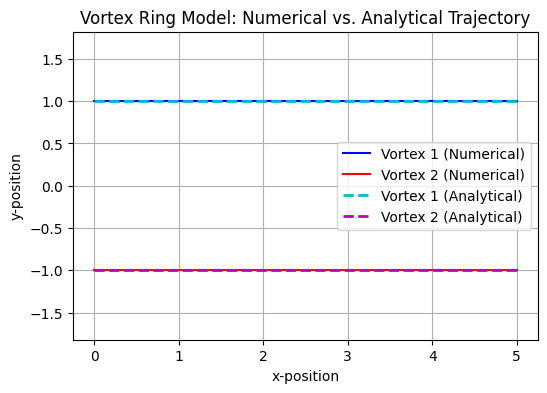

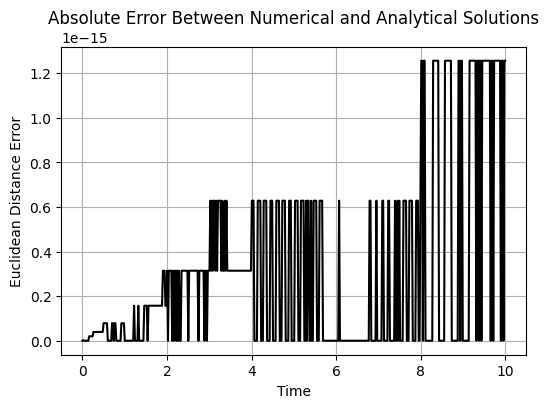

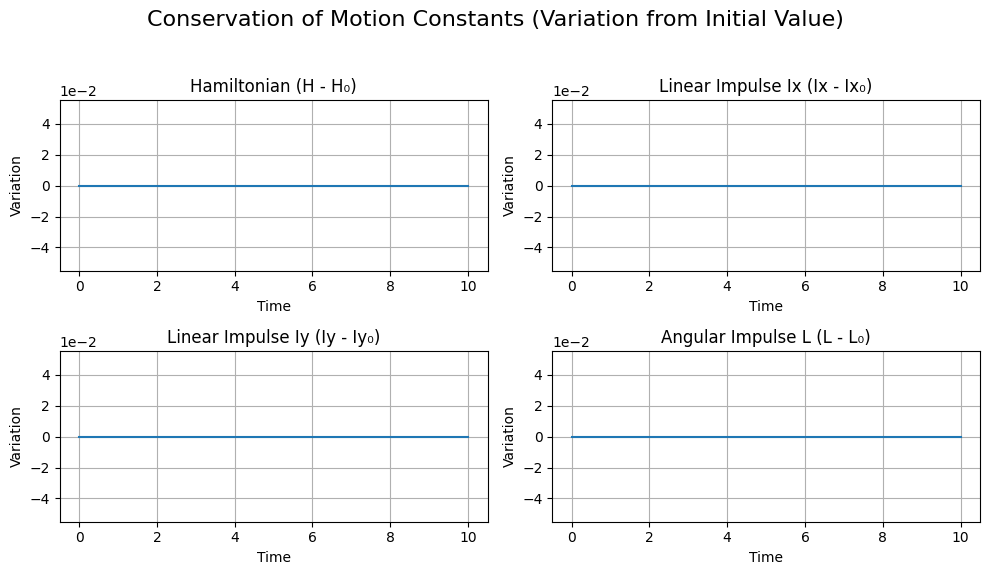

In [263]:
def calculate_conserved_quantities(solution, kappa):
    '''
    Calculates the Hamiltonian, linear impulses, and angular impulse over time.
    '''
    num_vortices = len(kappa)
    num_steps = solution.t.shape[0]

    # Reshape solution for easy access: (num_vortices, 2, num_steps)
    positions = solution.y.reshape((num_vortices, 2, num_steps))
    x_pos = positions[:, 0, :]
    y_pos = positions[:, 1, :]

    # Linear Impulses
    Ix = np.sum(kappa[:, np.newaxis] * x_pos, axis=0)
    Iy = np.sum(kappa[:, np.newaxis] * y_pos, axis=0)

    # Angular Impulse
    L = np.sum(kappa[:, np.newaxis] * (x_pos**2 + y_pos**2), axis=0)

    # Hamiltonian (only for two-vortex case for simplicity)
    if num_vortices == 2:
        r12_sq = (x_pos[0,:] - x_pos[1,:])**2 + (y_pos[0,:] - y_pos[1,:])**2
        H = -(kappa[0] * kappa[1] / (2 * np.pi)) * np.log(np.sqrt(r12_sq))
    else:
        H = np.full(num_steps, np.nan) # Placeholder for >2 vortices

    return {
        'H': H,
        'Ix': Ix,
        'Iy': Iy,
        'L': L
    }

def run_vortex_ring_investigation():
    '''
    Investigates the vortex ring model, compares with the analytical solution,
    and checks the conservation of motion constants.
    '''
    KAPPA = 2 * np.pi  # Choose kappa to make U=1 for a=1
    A = 2.0           # Separation distance
    kappa_vec = np.array([KAPPA, -KAPPA])
    initial_pos = np.array([[0.0, A / 2], [0.0, -A / 2]])
    t_span = (0, 10)
    solution = setup_and_run_simulation(initial_pos, kappa_vec, t_span, rtol=1e-9)

    # Compute analytical solution
    U = KAPPA / (2 * np.pi * A)
    t = solution.t
    analytical_pos = np.zeros_like(solution.y)
    analytical_pos[0, :] = U * t      # Vortex 1: x(t)
    analytical_pos[1, :] = A / 2      # Vortex 1: y(t)
    analytical_pos[2, :] = U * t      # Vortex 2: x(t)
    analytical_pos[3, :] = -A / 2     # Vortex 2: y(t)

    # Compare and calculate error
    error = np.sqrt(np.sum((solution.y - analytical_pos)**2, axis=0))

    # Check conservation of constants
    constants = calculate_conserved_quantities(solution, kappa_vec)

    # Calculate variation from initial value
    H_var = constants['H'] - constants['H'][0]
    Ix_var = constants['Ix'] - constants['Ix'][0]
    Iy_var = constants['Iy'] - constants['Iy'][0]
    L_var = constants['L'] - constants['L'][0]

    # Trajectories
    plt.figure(figsize=(6, 4))
    plt.title('Vortex Ring Model: Numerical vs. Analytical Trajectory')
    # Numerical
    plt.plot(solution.y[0,:], solution.y[1,:], 'b-', label='Vortex 1 (Numerical)')
    plt.plot(solution.y[2,:], solution.y[3,:], 'r-', label='Vortex 2 (Numerical)')
    # Analytical
    plt.plot(analytical_pos[0,:], analytical_pos[1,:], 'c--', lw=2, label='Vortex 1 (Analytical)')
    plt.plot(analytical_pos[2,:], analytical_pos[3,:], 'm--', lw=2, label='Vortex 2 (Analytical)')
    plt.xlabel('x-position'); plt.ylabel('y-position')
    plt.grid(True); plt.axis('equal'); plt.legend()
    plt.show()

    # Absolute error
    plt.figure(figsize=(6, 4))
    plt.plot(t, error, 'k-')
    plt.title('Absolute Error Between Numerical and Analytical Solutions')
    plt.xlabel('Time'); plt.ylabel('Euclidean Distance Error')
    plt.grid(True)
    plt.show()

    # Conservation of constants
    fig, axs = plt.subplots(2, 2, figsize=(10, 6))
    fig.suptitle('Conservation of Motion Constants (Variation from Initial Value)', fontsize=16)
    axs[0, 0].plot(t, H_var); axs[0, 0].set_title('Hamiltonian (H - H₀)');
    axs[0, 1].plot(t, Ix_var); axs[0, 1].set_title('Linear Impulse Ix (Ix - Ix₀)');
    axs[1, 0].plot(t, Iy_var); axs[1, 0].set_title('Linear Impulse Iy (Iy - Iy₀)');
    axs[1, 1].plot(t, L_var); axs[1, 1].set_title('Angular Impulse L (L - L₀)');
    for ax in axs.flat:
        ax.set(xlabel='Time', ylabel='Variation')
        ax.grid(True)
        ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

run_vortex_ring_investigation()

We first consider two identical smoke rings where they have the same strength and the same initial width. Initially, the two rings travel towards each other at a constant speed. As they get closer, they both begin to slow down and simultaneously expand in diameter. The rings continue to expand to infinity and slow down until they momentarily stop their forward motion.

The general case is a collision between non-equal rings. The two rings move towards each other and soon interact. Both are forced to expand due to the other's velocity field. The fast ring has a more potent velocity field and exerts a greater expanding force on the slow ring compared to vice versa. This causes the slow ring to expand and halt its forward progress before reversing direction. The fast ring also expands and reverses direction but to a lesser extent.

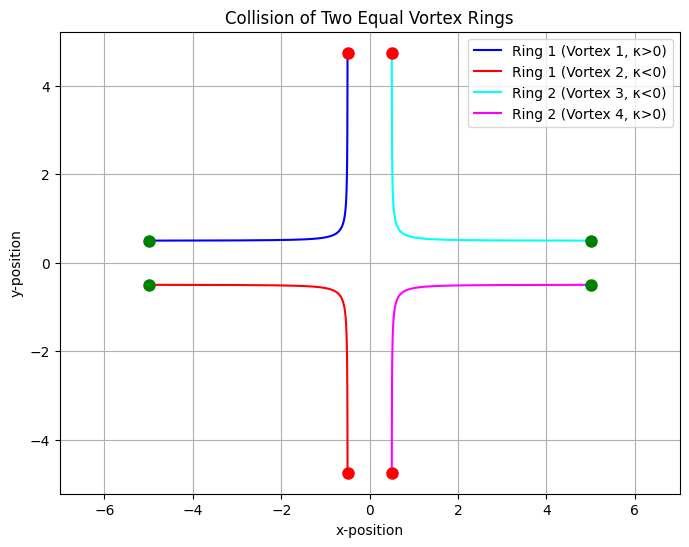

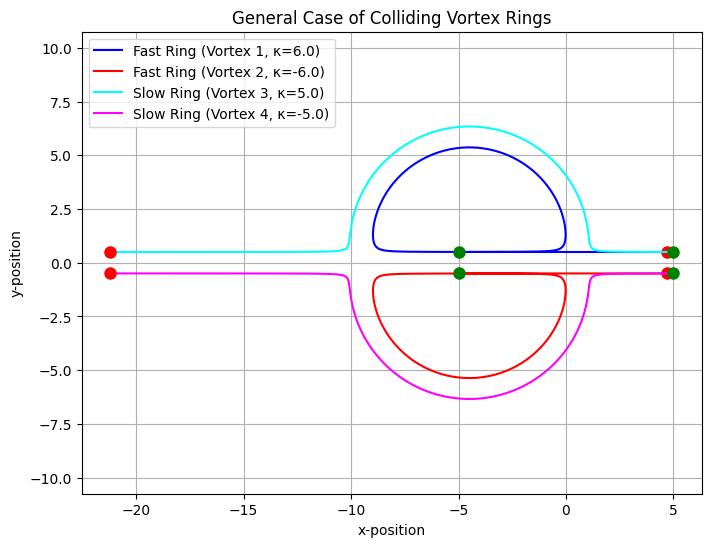

In [264]:
def plot_ring_trajectories(solution, labels, title):
    plt.figure(figsize=(8, 6))
    plt.title(title)

    num_vortices = len(labels)
    colors = ['blue', 'red', 'cyan', 'magenta']

    # Plot trajectories
    for i in range(num_vortices):
        plt.plot(solution.y[2*i, :], solution.y[2*i+1, :], color=colors[i], label=labels[i])
        # Mark start points with green circles
        plt.plot(solution.y[2*i, 0], solution.y[2*i+1, 0], 'go', markersize=8)
        # Mark end points with red circles
        plt.plot(solution.y[2*i, -1], solution.y[2*i+1, -1], 'ro', markersize=8)

    plt.xlabel('x-position')
    plt.ylabel('y-position')
    plt.grid(True)
    plt.axis('equal')
    plt.legend()
    plt.show()

def run_equal_rings_collision():
    KAPPA = 6.0
    WIDTH = 1.0
    START_POS = -5.0
    kappa_vec = np.array([KAPPA, -KAPPA, -KAPPA, KAPPA])

    initial_pos = np.array([
        [START_POS, WIDTH/2],      # Ring 1, Vortex 1
        [START_POS, -WIDTH/2],     # Ring 1, Vortex 2
        [-START_POS, WIDTH/2],     # Ring 2, Vortex 3
        [-START_POS, -WIDTH/2]     # Ring 2, Vortex 4
    ])

    labels = [
        'Ring 1 (Vortex 1, κ>0)', 'Ring 1 (Vortex 2, κ<0)',
        'Ring 2 (Vortex 3, κ<0)', 'Ring 2 (Vortex 4, κ>0)'
    ]

    t_span = (0, 10)
    solution = setup_and_run_simulation(initial_pos, kappa_vec, t_span)
    plot_ring_trajectories(solution, labels, 'Collision of Two Equal Vortex Rings')

def run_general_case_collision():
    KAPPA_FAST = 6.0
    KAPPA_SLOW = 5.0
    WIDTH = 1.0
    START_POS = -5.0
    kappa_vec = np.array([KAPPA_FAST, -KAPPA_FAST, -KAPPA_SLOW, KAPPA_SLOW])

    initial_pos = np.array([
        [START_POS, WIDTH/2],       # Ring 1 (Fast), Vortex 1
        [START_POS, -WIDTH/2],      # Ring 1 (Fast), Vortex 2
        [-START_POS, WIDTH/2],        # Ring 2 (Slow), Vortex 3
        [-START_POS, -WIDTH/2]        # Ring 2 (Slow), Vortex 4
    ])

    labels = [
        f'Fast Ring (Vortex 1, κ={KAPPA_FAST})', f'Fast Ring (Vortex 2, κ={-KAPPA_FAST})',
        f'Slow Ring (Vortex 3, κ={KAPPA_SLOW})', f'Slow Ring (Vortex 4, κ={-KAPPA_SLOW})'
    ]

    t_span = (0, 40)
    solution = setup_and_run_simulation(initial_pos, kappa_vec, t_span, t_eval_points=2000)
    plot_ring_trajectories(solution, labels, 'General Case of Colliding Vortex Rings')

run_equal_rings_collision()
run_general_case_collision()

Turning to two smoke rings interacting travelling in the same direction, let us first take the case of equal strength rings. The velocity field generated by the front ring affects the back ring and causes it to contract. As the back ring contracts, its self-propelled velocity increases. The velocity field generated by the back ring also affects the front ring and causes it to expand. As the front ring expands, its self-propelled velocity decreases.

The rear ring will inevitably catch up to the front ring. As it does, it will have shrunk in size, allowing it to pass through the center of the now-expanded front ring. After it passes, the roles will reverse. This is a perfectly symmetric version of the leapfrogging phenomenon.

In the general case, we assume one ring is inherently faster than the other. We place the faster ring behind the slower ring, otherwise there is little interaction as the faster ring moves further and further away. A similar leapfrogging interaction happens initially but the ring with higher initial energy eventually escapes the influence of the other ring, and the gap between the rings grows larger.

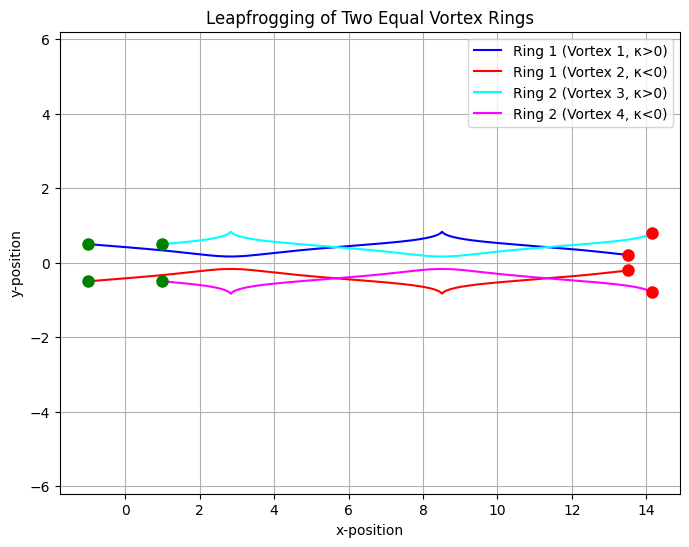

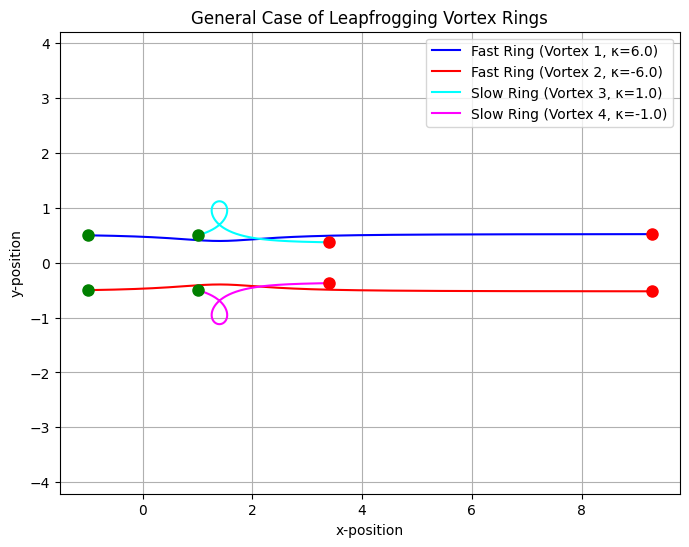

In [265]:
def run_equal_rings_leapfrogging():
    KAPPA = 6.0
    WIDTH = 1.0
    START_POS = -1.0
    kappa_vec = np.array([KAPPA, -KAPPA, KAPPA, -KAPPA])

    initial_pos = np.array([
        [START_POS, WIDTH/2],      # Ring 1, Vortex 1
        [START_POS, -WIDTH/2],     # Ring 1, Vortex 2
        [-START_POS, WIDTH/2],     # Ring 2, Vortex 3
        [-START_POS, -WIDTH/2]     # Ring 2, Vortex 4
    ])

    labels = [
        'Ring 1 (Vortex 1, κ>0)', 'Ring 1 (Vortex 2, κ<0)',
        'Ring 2 (Vortex 3, κ>0)', 'Ring 2 (Vortex 4, κ<0)'
    ]
    t_span = (0, 10)
    solution = setup_and_run_simulation(initial_pos, kappa_vec, t_span)
    plot_ring_trajectories(solution, labels, 'Leapfrogging of Two Equal Vortex Rings')

def run_general_case_leapfrogging():
    KAPPA_FAST = 6.0
    KAPPA_SLOW = 1.0
    WIDTH = 1.0
    START_POS = -1.0
    kappa_vec = np.array([KAPPA_FAST, -KAPPA_FAST, KAPPA_SLOW, -KAPPA_SLOW])

    initial_pos = np.array([
        [START_POS, WIDTH/2],       # Ring 1 (Fast), Vortex 1
        [START_POS, -WIDTH/2],      # Ring 1 (Fast), Vortex 2
        [-START_POS, WIDTH/2],      # Ring 2 (Slow), Vortex 3
        [-START_POS, -WIDTH/2]      # Ring 2 (Slow), Vortex 4
    ])

    labels = [
        f'Fast Ring (Vortex 1, κ={KAPPA_FAST})', f'Fast Ring (Vortex 2, κ={-KAPPA_FAST})',
        f'Slow Ring (Vortex 3, κ={KAPPA_SLOW})', f'Slow Ring (Vortex 4, κ={-KAPPA_SLOW})'
    ]
    t_span = (0, 10)
    solution = setup_and_run_simulation(initial_pos, kappa_vec, t_span, t_eval_points=3000)
    plot_ring_trajectories(solution, labels, 'General Case of Leapfrogging Vortex Rings')

run_equal_rings_leapfrogging()
run_general_case_leapfrogging()

*   Reduction from 3D to 2D, axisymmetry:
    
    We assume the smoke ring is perfectly circular and that its motion and interaction with other rings remain perfectly symmetric around a central axis. This allows us to analyse a single 2D cross-section. For a single, stable ring traveling in still air, it is a reasonably good approximation. It correctly captures the primary mechanism of self-propulsion, but it completely hides the possibility of 3D instabilities.

*   Point vortices:

    We model the cross-section of the smoke ring's core, which has a finite size and a complex velocity distribution, as two points where all the vorticity is concentrated. This is a fair approximation as long as the distance between interacting vortices is much larger than the actual core radius of the smoke ring. However, it prevents the model from describing what happens if the rings get so close that their cores touch, deform, or merge. The velocity field is singular, which is not physical.

*   Inviscid fluid:

    We assume the fluid has zero viscosity. In this ideal fluid, kinetic energy is conserved, and vortex structures persist forever. For fast-moving smoke rings over short timescales, the Reynolds number is high, meaning inertial forces dominate viscous forces. In this regime, the inviscid assumption is good for predicting the primary motion. However, it is fundamentally wrong over longer times due to the presence of viscosity causing the smoke rings to slow down, diffuse, and dissipate.

The leapfrogging phenomenon is well-documented behaviour in physical systems, including smoke rings in air, vortex rings in water, and within quantum superfluids. The explanation that the front ring expands and slows down because the rear ring's velocity field pushes its cross-section apart is accurate.
The explanation that the rear ring contracts and speeds up because the front ring's velocity field pulls its cross-section together is also accurate.

Our simple model neglects several important real-world effects:
*   3D instabilities;
*   Viscous diffusion and dissipation (leapfrogging);
*   Finite vortex core effects; (collisions);
*   Perfect formation (sensitivity to initial conditions);
*   External forces (buoyancy/thermodynamics/turbulence).

Due to a tolerance error, our simulation is likely to be quite sensitive and accumulate errors over time. The system of four point vortices is known to be chaotic.